#### **Context**

The <a href="https://www.kaggle.com/datasets/jillanisofttech/market-segmentation-in-insurance-unsupervised">sample Dataset</a> summarizes the usage behavior of about 9000 active credit cardholders during the last 6 months. The file is at a customer level with 18 behavioral variables.

##### **Credit Card Dataset Column Meanings**

| Column Name | Meaning in Credit Card Context |
|-------------|-------------------------------|
| CUST_ID | Unique identifier for each customer |
| BALANCE | Average balance amount maintained on the credit card |
| BALANCE_FREQUENCY | How frequently the customer maintains a balance (0-1 scale) |
| PURCHASES | Total amount of purchases made using the credit card |
| ONEOFF_PURCHASES | Total amount spent on one-time/single purchases |
| INSTALLMENTS_PURCHASES | Total amount spent on installment purchases |
| CASH_ADVANCE | Total amount taken as cash advances from the credit card |
| PURCHASES_FREQUENCY | How frequently the customer makes purchases (0-1 scale) |
| ONEOFF_PURCHASES_FREQUENCY | How frequently the customer makes one-time purchases (0-1 scale) |
| PURCHASES_INSTALLMENTS_FREQUENCY | How frequently the customer makes installment purchases (0-1 scale) |
| CASH_ADVANCE_FREQUENCY | How frequently the customer takes cash advances (0-1 scale) |
| CASH_ADVANCE_TRX | Number of cash advance transactions made |
| PURCHASES_TRX | Number of purchase transactions made |
| CREDIT_LIMIT | Maximum credit limit available on the card |
| PAYMENTS | Total amount of payments made to the credit card |
| MINIMUM_PAYMENTS | Total amount of minimum payments made |
| PRC_FULL_PAYMENT | Percentage of full payments made (vs. partial payments) |
| TENURE | Number of months the customer has held the credit card |

### Importing necessary packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest, RandomForestRegressor, RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, VarianceThreshold, mutual_info_regression
from sklearn.model_selection import train_test_split
import shap
from kneed import KneeLocator
from scipy.spatial.distance import cdist

from utils.cluster_visualizer import ClusterVisualizer

import warnings
warnings.filterwarnings('ignore')

### Importing Data and Exploring it

In [2]:
if os.path.exists("dataset\\df_cleaned.csv"):
    df = pd.read_csv("dataset\\df_cleaned.csv")
else:
    df = pd.read_csv("dataset/Customer_Data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   float64
 12  PURCHA

There are some missing values but another than this, the dataset columns are correct and they don't need transformation.

In [4]:
null_counts = df.isna().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

The dataset is pretty clean. In total we have 314 missing values which is not a big deal.

Instead of dropping rows, I will fill them later on.

In [5]:
df.describe(include='all')

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
unique,8950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,C19190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.129959,1733.143852,941.020949,0.153715,11.517318
std,NaN,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.737947,2895.063757,2764.097378,0.292499,1.338331
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,NaN,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,165.614015,0.000000,12.000000
50%,NaN,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,302.156406,0.000000,12.000000
75%,NaN,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,817.387500,0.142857,12.000000


   **Key Financial Metrics**
| Metric | Mean | Std Dev | 25% | 50% | 75% | Max |
|--------|------|---------|-----|-----|-----|-----|
| Balance | $1,564 | $2,082 | $128 | $873 | $2,054 | $19,043 |
| Total Purchases | $1,003 | $2,137 | $40 | $361 | $1,110 | $49,040 |
| Credit Limit | $4,494 | $3,639 | $1,600 | $3,000 | $6,500 | $30,000 |

   **Customer Behavior Insights**
1. **Spending Patterns**:
   - One-off purchases (mean: $592) are more common than installments (mean: $411)
   - 25% of customers made no one-off purchases
   - Purchase frequency is bimodal (mean: 0.49) - customers either rarely buy or buy frequently

2. **Cash Advances**:
   - 50% of customers never take cash advances
   - For those who do, average advance is $979 (high std dev: $2,097)
   - Maximum cash advance: $47,137

3. **Payment Behavior**:
   - Average payment: $1,733 (wide variation: std dev $2,895)
   - Minimum payments show extreme range ($0.02 to $76,406)
   - Only 15% of customers consistently pay their full balance

   **Notable Findings**
- **Right-skewed distributions**: Most financial metrics have means significantly higher than medians
- **Dormant accounts**: Significant portion of customers show minimal activity
- **High-value outliers**: Small percentage of customers with extremely high balances/purchases

### Preprocessing

In [6]:
if not os.path.exists("dataset\\df_cleaned.csv"):
    # Drop CUST_ID column before processing
    cust_id_df = df['CUST_ID']
    df = df.drop('CUST_ID', axis=1)
    # Handle missing values by applying IterativeImputer with RandomForestRegressor
    df_numeric = df.copy()
    imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=50, random_state=42))
    df = pd.DataFrame(
        imputer.fit_transform(df_numeric), 
        columns=df_numeric.columns,
        index=df_numeric.index
    )

    df.insert(loc=0, column='CUST_ID', value=cust_id_df)

### Feature Engineering

In [7]:
df_risk = df.copy()

In [8]:
def create_payment_behavior_features(df):
    """
    Create engineered features for payment behavior analysis
    """
    # Make a copy to avoid modifying original data
    df_features = df.copy()
    
    # 1. Credit Utilization Metrics
    df_features['credit_utilization_ratio'] = df_features['BALANCE'] / df_features['CREDIT_LIMIT'] ## keep
    df_features['effective_utilization'] = (df_features['BALANCE'] + df_features['PURCHASES']) / df_features['CREDIT_LIMIT']
    
    # 2. Payment Efficiency Indicators
    df_features['payment_to_balance_ratio'] = df_features['PAYMENTS'] / (df_features['BALANCE'] + 1)   ## keep
    df_features['payment_coverage'] = df_features['PAYMENTS'] / (df_features['PURCHASES'] + 1)
    
    # Handle missing MINIMUM_PAYMENTS
    df_features['MINIMUM_PAYMENTS'].fillna(df_features['MINIMUM_PAYMENTS'].median(), inplace=True)
    df_features['min_payment_ratio'] = df_features['PAYMENTS'] / (df_features['MINIMUM_PAYMENTS'] + 1)
    
    # 3. Payment Behavior Classification
    df_features['revolver_flag'] = (df_features['PRC_FULL_PAYMENT'] < 0.8).astype(int)
    
    # Payment type categories
    conditions = [
        df_features['PRC_FULL_PAYMENT'] >= 0.9,
        df_features['min_payment_ratio'] >= 2,
        df_features['min_payment_ratio'] >= 0.8
    ]
    choices = ['Full_Payer', 'Above_Minimum', 'Minimum_Payer']
    df_features['payment_type'] = np.select(conditions, choices, default='Below_Minimum')
    
    # 4. Spending vs Payment Balance
    df_features['net_cash_flow'] = df_features['PAYMENTS'] - df_features['PURCHASES']
    df_features['spending_sustainability'] = df_features['PAYMENTS'] / (df_features['PURCHASES'] + df_features['CASH_ADVANCE'] + 1) ## keep
    df_features['months_to_payoff'] = df_features['BALANCE'] / (df_features['PAYMENTS'] + 1) ## keep
    
    # 5. Cash Advance Behavior
    total_spending = df_features['PURCHASES'] + df_features['CASH_ADVANCE']
    df_features['cash_advance_dependency'] = df_features['CASH_ADVANCE'] / (total_spending + 1) ## keep
    df_features['ca_vs_purchase_freq_ratio'] = df_features['CASH_ADVANCE_FREQUENCY'] / (df_features['PURCHASES_FREQUENCY'] + 0.01)
    
    # 6. Activity and Transaction Patterns
    df_features['total_activity'] = df_features['PURCHASES_FREQUENCY'] + df_features['CASH_ADVANCE_FREQUENCY'] ## keep
    df_features['avg_purchase_size'] = df_features['PURCHASES'] / (df_features['PURCHASES_TRX'] + 1)
    
    # Purchase size categories
    df_features['purchase_size_category'] = pd.cut(
        df_features['avg_purchase_size'], 
        bins=[0, 100, 500, float('inf')], 
        labels=['Small', 'Medium', 'Large']
    )
    
    # 7. Financial Health Indicators
    df_features['debt_to_limit'] = df_features['BALANCE'] / df_features['CREDIT_LIMIT']
    df_features['payment_capacity'] = df_features['CREDIT_LIMIT'] - df_features['BALANCE']
    df_features['financial_stress'] = (df_features['BALANCE'] + df_features['MINIMUM_PAYMENTS']) / df_features['CREDIT_LIMIT']
    
    # 8. Tenure-Adjusted Features
    df_features['monthly_purchases'] = df_features['PURCHASES'] / df_features['TENURE']
    df_features['monthly_payments'] = df_features['PAYMENTS'] / df_features['TENURE']
    df_features['purchases_per_tenure_month'] = df_features['PURCHASES_TRX'] / df_features['TENURE']
    
    # 9. Composite Risk Scores
    df_features['payment_risk_score'] = (
        (1 - df_features['PRC_FULL_PAYMENT']) * 40 +
        df_features['credit_utilization_ratio'] * 30 +
        df_features['cash_advance_dependency'] * 20 +
        (1 - df_features['BALANCE_FREQUENCY']) * 10
    )
    
    # Assuming 18% APR for interest calculation
    df_features['customer_value_score'] = (
        df_features['PURCHASES'] * 0.4 +
        (df_features['BALANCE'] * 0.18/12) * 0.6 +
        df_features['CASH_ADVANCE'] * 0.05
    )
    
    return df_features

X = create_payment_behavior_features(df_risk)

### Feature Selection

In [9]:
def unsupervised_feature_selection(df, variance_threshold=0.01, correlation_threshold=0.8):
    """
    Perform feature selection for unsupervised learning while keeping original column names

    Parameters:
    - df: DataFrame with numerical features
    - variance_threshold: Remove features with variance below this threshold
    - correlation_threshold: Remove one feature from pairs with correlation above this
    - target_col: Column to use for mutual info calculation (optional)
    """

    # Start with all numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    selected_features = numerical_cols.copy()
    print(f"Starting with {len(selected_features)} numerical features")

    # 1. Remove low variance features
    selector = VarianceThreshold(threshold=variance_threshold)
    selector.fit(df[selected_features])
    low_variance_features = [feat for feat, selected in zip(selected_features, selector.get_support()) if not selected]
    selected_features = [feat for feat in selected_features if feat not in low_variance_features]
    print(f"Removed {len(low_variance_features)} low variance features")
    print(f"Low variance features: {low_variance_features}")

    # 2. Remove highly correlated features
    corr_matrix = df[selected_features].corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    high_corr_pairs = []
    to_drop = set()

    for col in upper_tri.columns:
        correlated_features = upper_tri[col][upper_tri[col] > correlation_threshold].index.tolist()
        for corr_feat in correlated_features:
            high_corr_pairs.append((col, corr_feat, upper_tri.loc[corr_feat, col]))
            # Keep the feature with higher variance
            if df[col].var() >= df[corr_feat].var():
                to_drop.add(corr_feat)
            else:
                to_drop.add(col)

    selected_features = [feat for feat in selected_features if feat not in to_drop]
    print(f"Removed {len(to_drop)} highly correlated features")
    print(f"High correlation pairs: {high_corr_pairs}")
    print(f"Dropped correlated features: {list(to_drop)}")

    print(f"\nFinal selected features ({len(selected_features)}): {selected_features}")

    return selected_features, {
        'low_variance_removed': low_variance_features,
        'high_corr_removed': list(to_drop),
        'correlation_pairs': high_corr_pairs
    }

# Usage example:
selected_features, removal_info = unsupervised_feature_selection(
    X,
    variance_threshold=0.01,
    correlation_threshold=0.9
)

# # Get your final dataset with selected features
X_to_scale = X[selected_features]

Starting with 38 numerical features
Removed 0 low variance features
Low variance features: []
Removed 6 highly correlated features
High correlation pairs: [('ONEOFF_PURCHASES', 'PURCHASES', np.float64(0.9168445587151489)), ('debt_to_limit', 'credit_utilization_ratio', np.float64(1.0)), ('monthly_purchases', 'PURCHASES', np.float64(0.9958452529150349)), ('monthly_purchases', 'ONEOFF_PURCHASES', np.float64(0.9130598273969466)), ('monthly_payments', 'PAYMENTS', np.float64(0.99202868491921)), ('purchases_per_tenure_month', 'PURCHASES_TRX', np.float64(0.995888357538573)), ('customer_value_score', 'PURCHASES', np.float64(0.9909809304364406)), ('customer_value_score', 'ONEOFF_PURCHASES', np.float64(0.9104692969661989)), ('customer_value_score', 'monthly_purchases', np.float64(0.9873043925441501))]
Dropped correlated features: ['credit_utilization_ratio', 'monthly_payments', 'customer_value_score', 'ONEOFF_PURCHASES', 'monthly_purchases', 'purchases_per_tenure_month']

Final selected features 

#### Preprocessing Data

In this experiment, I will not delete outliers since I don't know what is a real outlier in real life business.

In [10]:
# for col in ['BALANCE', 'PAYMENTS', 'MINIMUM_PAYMENTS']:
#         income_99th = X_to_scale[col].quantile(0.99)
#         X_to_scale = X_to_scale[X_to_scale[col] < income_99th]

Since most of the data is right skewed, I will apply `Log transformation` to fix the right skewness and reduce the scale of min/max values.

In [11]:
for feature in X_to_scale.select_dtypes(include=[np.number]).columns:
    if 'RATIO' not in feature:
        # Shift negative values to positive before log transform
        min_val = X_to_scale[feature].min()
        if min_val <= 0:
            X_to_scale[feature] = X_to_scale[feature] - min_val + 1  # Shift to positive range
            
        X_to_scale[feature] = np.log1p(X_to_scale[feature])

**Why Robust Scaling is Particularly Effective for Clustering**

- Clustering algorithms (like K-Means) are sensitive to outliers.
- Good for a dataset with 99% values (0-10) and 1% (1000+).
- When you have features that have different scales/distribution.
- Good for distance-based clustering

In [12]:
# RobustScaler features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_to_scale)
X_scaled = pd.DataFrame(X_scaled, columns=X_to_scale.columns, index=X_to_scale.index)

### Clustering Analysis

To determine the optimal number of clusters, I check if the difference is big (<= 1) then I choose silhouette score because it's more objective than KMeans and handles well the imblances in clusters.

Best kmeans clusters (Silhouette): 5 (score: 0.300)
Best hierarchical clusters (Silhouette): 2 (score: 0.274)


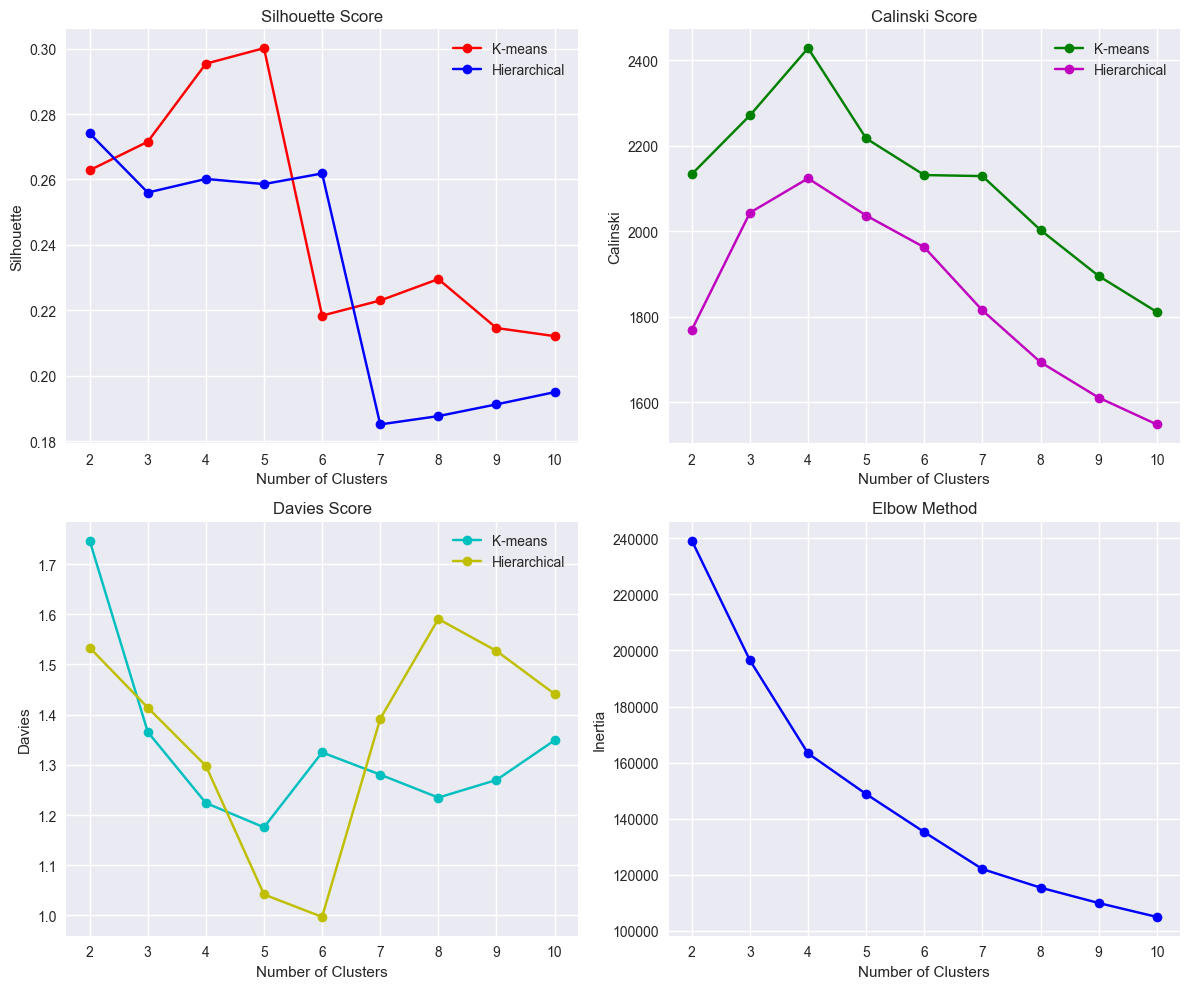

In [13]:
from sklearn.cluster import KMeans, AgglomerativeClustering
def evaluate_clusters(X, max_k=10):
    """Compact clustering evaluation with visualization"""
    K = range(2, max_k + 1)
    methods = {
        'kmeans': lambda k: KMeans(n_clusters=k, random_state=42, n_init=10).fit(X),
        'hierarchical': lambda k: AgglomerativeClustering(n_clusters=k, linkage='ward').fit_predict(X)
    }
    
    # Calculate all metrics
    results = {
        m: {
            'silhouette': [silhouette_score(X, methods[m](k).labels_ if m == 'kmeans' else methods[m](k)) for k in K],
            'calinski': [calinski_harabasz_score(X, methods[m](k).labels_ if m == 'kmeans' else methods[m](k)) for k in K],
            'davies': [davies_bouldin_score(X, methods[m](k).labels_ if m == 'kmeans' else methods[m](k)) for k in K],
            'inertia': [methods[m](k).inertia_ for k in K] if m == 'kmeans' else None
        } for m in methods
    }

    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    metrics = ['silhouette', 'calinski', 'davies']
    styles = [('ro-', 'bo-'), ('go-', 'mo-'), ('co-', 'yo-')]
    
    for i, (metric, (k_style, h_style)) in enumerate(zip(metrics, styles)):
        ax = axes[i//2, i%2]
        ax.plot(K, results['kmeans'][metric], k_style, label='K-means')
        ax.plot(K, results['hierarchical'][metric], h_style, label='Hierarchical')
        ax.set(xlabel='Number of Clusters', ylabel=metric.capitalize(), title=f'{metric.capitalize()} Score')
        ax.legend()
    
    axes[1,1].plot(K, results['kmeans']['inertia'], 'bo-', label='K-means Inertia')
    axes[1,1].set(xlabel='Number of Clusters', ylabel='Inertia', title='Elbow Method')
    plt.tight_layout()
    
    # Print best results
    for m in methods:
        best_k = K[np.argmax(results[m]['silhouette'])]
        print(f"Best {m} clusters (Silhouette): {best_k} (score: {max(results[m]['silhouette']):.3f})")

# Usage
evaluate_clusters(X_scaled)

##### Clustering Analysis: Optimal K Selection

**Overview**
This analysis examines four different metrics to determine the optimal number of clusters (K) for both K-means and hierarchical clustering algorithms.

**Results Summary**

| Metric | K-means Optimal | Hierarchical Optimal |
|--------|----------------|---------------------|
| Silhouette Score | K=5 | K=4-6 |
| Calinski-Harabasz | K=4 | K=4 |
| Davies-Bouldin | K=5 | K=6 |
| Elbow Method | K=4-5 | - |

**<u>NOTTE :</u>** After some testing I found out that **5 clusters** is the optimal one since it gives more clear segmentation.

In [14]:
### Perform K-means clustering
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

### Risk Segment Profiling

I'm use my original dataframe before scaling after clustering.

In [15]:
from utils.cluster_visualizer import ClusterVisualizer

visualizer = ClusterVisualizer(X_scaled, cluster_labels, selected_features, optimal_k)

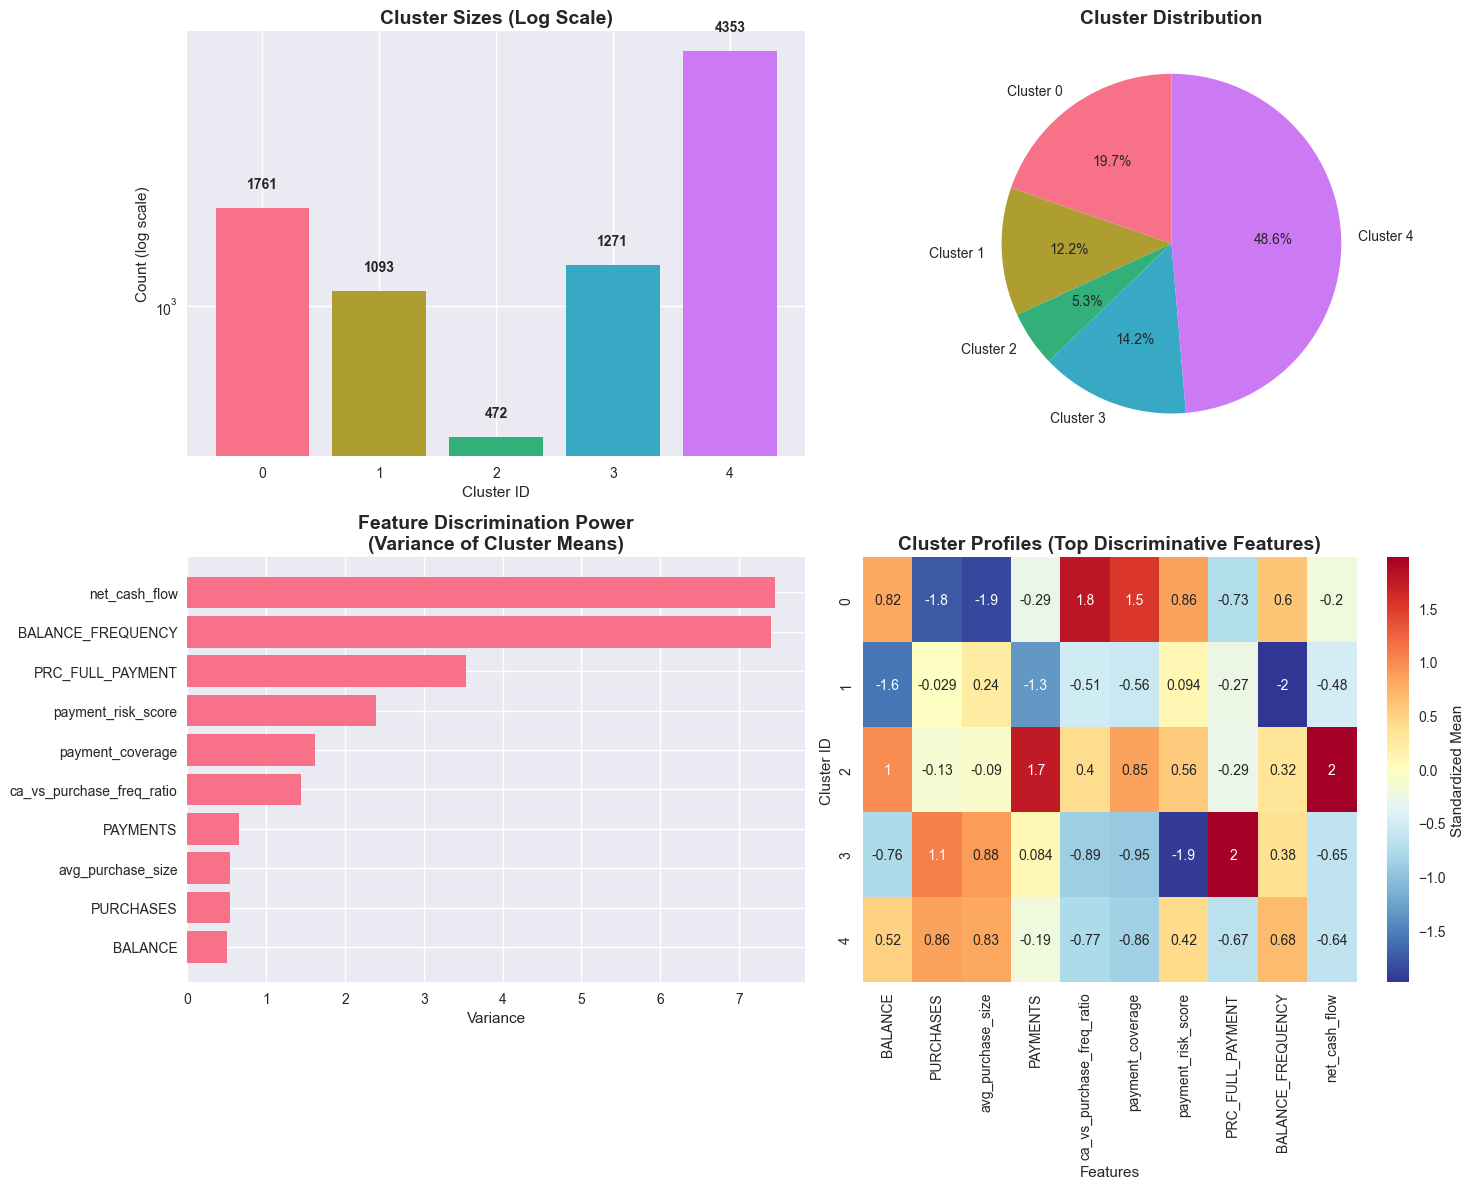

In [16]:
fig1, disc_features = visualizer.plot_cluster_overview()
fig1.show()

##### <u>**Credit Card Customer Segmentation Analysis (K=5)**</u>

**Customer Segment Distribution**
- **Segment 4**: 4,353 customers (48.6%) - Mainstream users
- **Segment 0**: 1,761 customers (19.7%) - High cash flow users
- **Segment 3**: 1,271 customers (14.2%) - High spenders, poor payment habits
- **Segment 1**: 1,093 customers (12.2%) - Low activity, payment issues
- **Segment 2**: 472 customers (5.3%) - Responsible full-payment users

**Key Behavioral Drivers**
1. **Net cash flow** - Primary differentiator
2. **Balance frequency** - Payment timing patterns
3. **Full payment percentage** - Debt management approach

##### <u>**Business Insights**</u>

**Major imbalance**: Nearly half your customers fall into one segment, indicating a large homogeneous group with similar spending/payment behaviors.

**Segment characteristics**:
- **Segment 0**: High-income convenience users
- **Segment 1**: Cautious/constrained users
- **Segment 2**: Most responsible customers (small but valuable)
- **Segment 3**: High-risk heavy users
- **Segment 4**: Average/typical customers (core base)

Next I'm going to plot the distribution of the clusters by most discriminative features and compare their average.

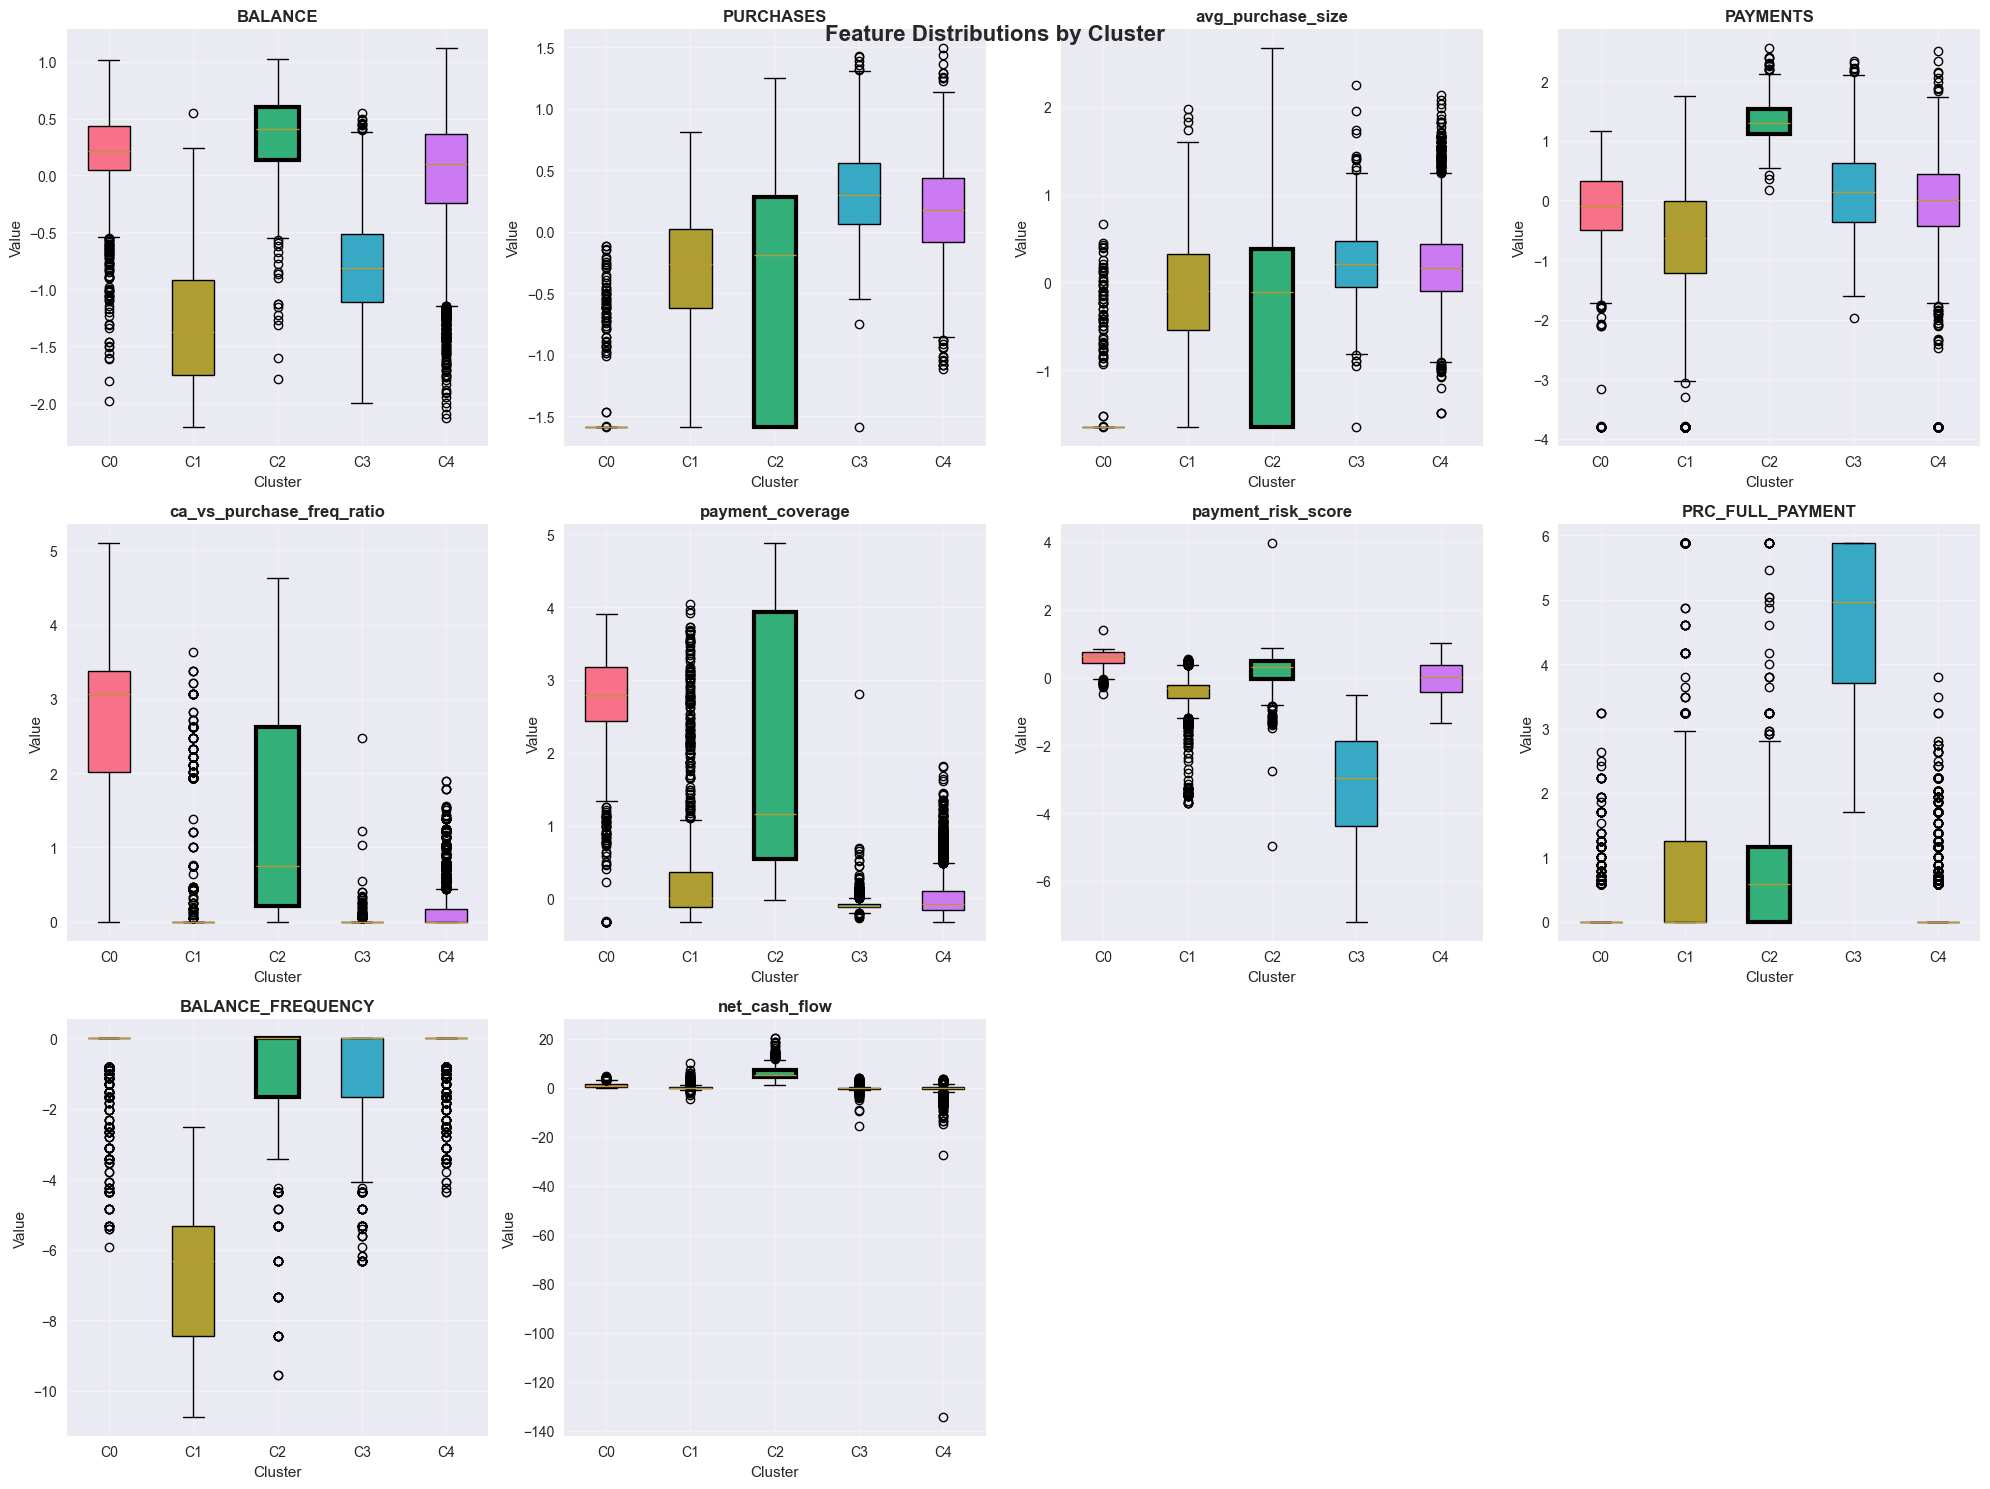

In [17]:
fig2 = visualizer.plot_feature_distributions(features=disc_features)
fig2.suptitle('Feature Distributions by Cluster', fontsize=16, fontweight='bold')
plt.show()

In [18]:
df_risk_final = pd.concat([pd.Series(cluster_labels, name='cluster_labels'), X], axis=1)
# Cluster summary statistics
cluster_summary = df_risk_final.groupby('cluster_labels').agg({
    'PRC_FULL_PAYMENT': 'mean',
    'BALANCE_FREQUENCY': 'mean', 
    'effective_utilization': 'mean',
    'cash_advance_dependency': 'mean',
    'payment_risk_score': 'mean',
    'PURCHASES': 'mean',
    'BALANCE': 'mean',
    'revolver_flag': 'mean',
    'payment_to_balance_ratio': 'mean',
    'debt_to_limit': 'mean'
}).round(3)

display(cluster_summary)

,PRC_FULL_PAYMENT,BALANCE_FREQUENCY,effective_utilization,cash_advance_dependency,payment_risk_score,PURCHASES,BALANCE,revolver_flag,payment_to_balance_ratio,debt_to_limit
cluster_labels,,,,,,,,,,
0,0.019,0.956,0.639,0.995,78.746,2.469,2335.292,1.000,1.175,0.638
1,0.144,0.336,0.162,0.215,46.172,321.640,81.081,0.940,93.278,0.033
2,0.131,0.886,0.587,0.749,64.840,951.884,3278.070,0.972,25.867,0.466
3,0.768,0.899,0.513,0.015,11.927,1995.395,193.542,0.468,13.787,0.045
4,0.034,0.974,0.827,0.237,57.724,1295.048,1839.591,1.000,2.418,0.469


##### **Customer Segment Feature Analysis**

**Key Segment Characteristics**

| Segment | Profile | Balance | Purchase Activity | Payment Behavior | Risk Level |
|---------|---------|---------|-------------------|------------------|------------|
| **Cluster 0** | High-Income Convenience | Positive | Moderate | Average | Low |
| **Cluster 1** | Low-Engagement | Negative | Minimal | Poor coverage/risk | Medium |
| **Cluster 2** | Premium Responsible | High positive | Large purchases | Excellent (6/6 full payment) | Very Low |
| **Cluster 3** | High-Risk Heavy | Negative | Moderate | Poor risk scores | High |
| **Cluster 4** | Mainstream | Slightly negative | Below average | Below average | Medium |

**Business Implications**

- **Cluster 0**: Growth opportunity - convenience users who could spend more
- **Cluster 1**: Dormant/inactive - potential churn candidates
- **Cluster 2**: Your most valuable customers - high spending, always pay
- **Cluster 3**: Highest risk - frequent balances, poor payment habits  
- **Cluster 4**: Core base requiring retention strategies

#### **Cluster Visualization Analysis**

In [ ]:
# Call the function
pca_coords, tsne_coords = visualizer.create_2d_visualizations(
    X_scaled, 
    cluster_labels
)

**PCA vs t-SNE Comparison**

| Method | Separation Quality | Overlap | Best For |
|--------|-------------------|---------|----------|
| **PCA** | Moderate | Significant overlap between clusters | Linear relationships, variance explanation |
| **t-SNE** | Excellent | Clear cluster boundaries | Non-linear patterns, visualization |

##### **Key Findings**

**PCA Results:**
- Explains 49.7% of total variance in first 2 components
- Shows significant cluster overlap, especially yellow (Cluster 4) with others
- Linear dimensionality reduction struggles with this dataset

**t-SNE Results:**
- Superior cluster separation with distinct boundaries
- Each cluster forms cohesive, well-separated groups
- Reveals non-linear relationships in customer behavior data

**Business Insight**

- The clear separation in t-SNE confirms your customer segments are **genuinely distinct behavioral groups**, not just statistical artifacts. The poor PCA separation suggests customer behaviors follow complex, non-linear patterns that simple linear analysis misses.

- This validates your segmentation strategy - customers truly fall into discrete behavioral categories rather than existing on simple linear spectrums.

In [ ]:
umap_coords = visualizer.create_umap_visualization(X_scaled, cluster_labels)

##### **Key Insights**

- **Best visualization method**: UMAP provides superior cluster definition vs PCA/t-SNE
- **Minimal overlap**: Best separation of the three methods with some boundary mixing which suggest that is some non-linear relationship among the features.
- **Size reflects reality**: Cluster 4's large area matches its 48.6% customer share
- **Behavioral continuity**: Smooth transitions suggest related customer behaviors

##### **Business Validation**

UMAP confirms that 5-segment strategy captures genuine behavioral differences. The clear separation validates targeted marketing approaches for each distinct customer group.

#### **Business Recommendations**

**Cluster 0: High-Risk Cash Advance Users**

- Profile: Low full-payment rate (1.9%), extreme cash-advance dependency (99.5%), high utilization (64%), high-risk score (78.7), and revolving balances.

- Risk: Severe default risk due to reliance on costly cash advances and minimal payments.

- Actions:

    - Reduce exposure: Lower credit limits or restrict cash-advance access.

    - Debt counseling: Offer free financial planning to reduce dependency on cash advances.

    - Targeted incentives: Promote balance transfers to lower-interest products.

    - Monitor closely: Flag for early collections intervention.

**Cluster 1: Low-Utilization, Occasional Revolvers**

- Profile: Moderate purchases, low utilization (16%), low balance, but revolve occasionally (94% revolver rate). Low risk (score: 46.2).

- Opportunity: Engaged but underutilizing credit capacity.

- Actions:

    - Increase spending: Offer rewards/cashback on daily spend categories (e.g., groceries, fuel).

    - Credit limit boosts: Incentivize spending with higher limits (low risk of overextension).

    - Retention focus: Introduce loyalty programs to deepen engagement.

**Cluster 2: High-Spending Revolvers with Cash Advance Reliance**

- Profile: High purchases ($951+), elevated cash-advance use (74.9%), moderate utilization (59%), high-risk score (64.8).

- Risk: Profitability from spend/interest but high default risk due to cash-advance habits.

- Actions:

    - Limit cash advances: Cap advance amounts or raise fees to discourage reliance.

    - Promote balance transfers: Offer low-interest teaser rates to consolidate debt.

    - Spending incentives: Shift behavior to purchases (e.g., "0% APR on purchases for 6 months").

**Cluster 3: Prime Full-Payers**

- Profile: High full-payment rate (76.8%), low risk (score: 11.9), large purchases ($1,995+), minimal cash advances (1.5%).

- Opportunity: Most valuable segment (low risk, high interchange revenue).

- Actions:

    - Reward loyalty: Premium rewards programs (e.g., travel perks, higher cashback).

    - Credit limit increases: Encourage larger purchases without risk.

    - Cross-sell: Offer premium cards, wealth management, or insurance products.

**Cluster 4: High-Utilization Revolvers**

- Profile: Very high utilization (83%), large purchases ($1,295+), moderate risk (score: 57.7), consistent revolvers.

- Risk: Overleveraged; borderline default risk.

- Actions:

    - Utilization management: Offer credit limit increases only if paired with financial education.

    - Debt restructuring: Low-interest installment plans for outstanding balances.

    - Behavioral nudges: Alerts for utilization thresholds and payment reminders.

In [54]:
from scipy.spatial.distance import cdist, pdist
import numpy as np
from scipy.stats import f_oneway, kruskal

def calculate_cluster_separation(data, labels):
    """Calculate cluster separation metrics"""
    # Intra-cluster distances (compactness)
    intra_distances = []
    for cluster_id in np.unique(labels):
        cluster_points = data[labels == cluster_id]
        if len(cluster_points) > 1:  # Need at least 2 points to calculate distance
            intra_dist = np.mean(pdist(cluster_points))
            intra_distances.append(intra_dist)
    avg_intra = np.mean(intra_distances) if intra_distances else 0

    # Inter-cluster distances (separation)
    inter_distances = []
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        # Not enough clusters to calculate inter-cluster distances
        return avg_intra, 0, 0

    for i in range(len(unique_labels)):
        for j in range(i+1, len(unique_labels)):
            cluster1 = data[labels == unique_labels[i]]
            cluster2 = data[labels == unique_labels[j]]
            if len(cluster1) > 0 and len(cluster2) > 0:  # Check for empty clusters
                inter_dist = np.mean(cdist(cluster1, cluster2))
                inter_distances.append(inter_dist)

    avg_inter = np.mean(inter_distances) if inter_distances else 0
    separation_ratio = avg_inter / avg_intra if avg_intra > 0 else float('inf')
    return avg_intra, avg_inter, separation_ratio

def robust_feature_testing(df, cluster_col='cluster_labels', features=None):
    """Test features for significant differences between clusters"""
    if features is None:
        features = [col for col in df.columns if col != cluster_col]

    results = {}

    for feature in features:
        # Skip non-numeric columns
        if not pd.api.types.is_numeric_dtype(df[feature]):
            continue

        # Get cluster values
        cluster_values = []
        cluster_ids = []
        for c in df[cluster_col].unique():
            group = df[df[cluster_col] == c][feature].dropna()

            # Only include if there's variance in the group
            if len(group) > 0:
                if len(group) == 1:
                    # For single-point clusters, duplicate the point to enable variance calculation
                    group = pd.Series([group.iloc[0], group.iloc[0]])
                cluster_values.append(group)
                cluster_ids.append(c)

        # Skip if insufficient valid clusters
        if len(cluster_values) < 2:
            results[feature] = {'p_value': np.nan, 'test': 'skipped', 'reason': 'not enough clusters'}
            continue

        try:
            # Try Kruskal-Wallis first (more robust to non-normal distributions)
            stat, p_value = kruskal(*cluster_values)
            results[feature] = {'p_value': p_value, 'test': 'Kruskal-Wallis'}
        except Exception as e:
            results[feature] = {'p_value': np.nan, 'test': 'failed', 'error': str(e)}

    return pd.DataFrame(results).T

# Assuming X_scaled is your scaled feature data and cluster_labels contains cluster assignments
intra, inter, ratio = calculate_cluster_separation(X_scaled, cluster_labels)
print(f"Average intra-cluster distance: {intra:.3f}")
print(f"Average inter-cluster distance: {inter:.3f}")
print(f"Separation ratio: {ratio:.1f}")  # Higher is better (>3 is good)

# Create cluster profiles
profile = df_risk_final.groupby('cluster_labels')[disc_features].mean()
print("\nCluster Profiles:")
print(profile)

# Validate features with robust testing
print("\nFeature significance testing:")
feature_results = robust_feature_testing(df_risk_final, 'cluster_labels', disc_features)
print(feature_results[['p_value', 'test']])


Average intra-cluster distance: 5.530
Average inter-cluster distance: 9.448
Separation ratio: 1.7

Cluster Profiles:
                    BALANCE    PURCHASES  avg_purchase_size     PAYMENTS  \
cluster_labels                                                             
0               2335.292045     2.468807           1.005911  1078.292104   
1                 81.080670   321.640146          62.294880   739.102163   
2               3278.069674   951.884407          65.884179  8701.005090   
3                193.542120  1995.395413          73.337581  2034.968068   
4               1839.590702  1295.048472          74.912046  1403.998989   

                ca_vs_purchase_freq_ratio  payment_coverage  \
cluster_labels                                                
0                               27.174170       1022.465900   
1                                2.256861        126.046849   
2                               12.961511       3113.261582   
3                                0.

In [ ]:
import numpy as np
from scipy.stats import f_oneway

def calculate_effect_size(data, labels):
    """
    Calculate the effect size (eta-squared) for an ANOVA test.

    Parameters:
    - data: A NumPy array or pandas Series containing the data.
    - labels: A NumPy array or pandas Series containing the cluster labels.

    Returns:
    - f_stat: The F-statistic from the ANOVA test.
    - p_value: The p-value from the ANOVA test.
    - eta_squared: The effect size (eta-squared).
    """
    # Extract group data based on unique labels
    group_data = [data[labels == label] for label in np.unique(labels)]

    # Perform ANOVA
    f_stat, p_value = f_oneway(*group_data)

    # Ensure f_stat and p_value are single float values
    if isinstance(f_stat, np.ndarray):
        f_stat = f_stat[0]
    if isinstance(p_value, np.ndarray):
        p_value = p_value[0]

    # Calculate the total sum of squares
    grand_mean = np.mean(data)
    ss_total = np.sum((data - grand_mean) ** 2)

    # Calculate the between-group sum of squares
    ss_between = sum(len(group) * (np.mean(group) - grand_mean) ** 2 for group in group_data)

    # Calculate eta-squared
    eta_squared = ss_between / ss_total

    return float(f_stat), float(p_value), eta_squared

# Example usage:
# Assuming df_risk_final is your DataFrame and 'cluster_labels' is the column with cluster assignments
# Select the first feature column for demonstration
data = df_risk_final[disc_features].values  # Convert to NumPy array
labels = df_risk_final['cluster_labels'].values  # Convert to NumPy array

# Calculate effect size
f_stat, p_value, eta_squared = calculate_effect_size(data, labels)

# Print results
print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_value:.4f}")
print(f"Eta-squared: {eta_squared:.3f}")


F-statistic: 541.231
P-value: 0.0000
Eta-squared: 0.007
